In [1]:
%matplotlib inline

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score, make_scorer

In [3]:
# random seed = 13

## Почистване на данни

In [4]:
rent_ads_data = pd.read_excel('Python hackathon_Mock data_Group 3 .xlsx', sheet_name='Наеми', skiprows=1, header = 1)

In [5]:
rent_ads_data.head()

,Обява №,Дата на публикуване,Заглавие,Описание,Област,Град,Район/Квартал,Етаж,Наем (в лв.),Наем (в евро),Площ,Цена на кв.м. (в лв.),Спални,От агенция,Подател,Телефон,Идентифициран риск за фалшива обява
0,1276.0,2022-09-25,Дава под Наем 1-СТАЕН,ЕКСКЛУЗИВНА ОФЕРТА\n\n'БЕСТ СЕЛЪРС' предлага н...,София,София,Изток,8.0,NaN,275.0,49.0,10.976597,1.0,Да,Агенция: БЕСТ СЕЛЪРС ООД,886224488.0,Не
1,1388.0,2022-09-26,Дава под Наем 1-СТАЕН,Топ локация!!!\n\nСлед ремонт - напълно обзаве...,София,София,Белите брези,NaN,450.0,NaN,40.0,11.250000,1.0,Да,Агенция: УПРАВЛЕНИЕ БГ,884231053.0,Не
2,1500.0,2022-09-27,Дава под Наем 1-СТАЕН,"Предлагаме малко,но функционално жилище,в мног...",София,София,Редута,0.0,400.0,NaN,30.0,13.330000,1.0,Да,Агенция: АГЕНЦИИ ИЗТОК - ОФИС ТОВИСТО М,988829752.0,Не
3,1612.0,2022-09-28,Дава под Наем 1-СТАЕН,На вашето внимание агенция за недвижими имоти ...,София,София,Разсадника,2.0,NaN,250.0,47.0,10.463691,1.0,Да,Агенция: ПИЙК РИЪЛ ЕСТЕЙТ ЕООД,882988975.0,Не
4,1724.0,2022-09-29,Дава под Наем 1-СТАЕН,БЕЗ ХАЗАЙ на спирката с/у Медицинска а-мия. Ст...,София,София,Медицинска ададемия,1.0,380.0,NaN,25.0,15.200000,1.0,Да,Агенция:ЛАЙТ ПРОПЪРТИ,878318739.0,Да


In [6]:
rent_ads_data.shape

(98, 17)

####  Форматиране на телефонен номер 

In [7]:
rent_ads_data['Телефон'] = rent_ads_data['Телефон'].astype(str).str.replace(' ', '').str.rstrip('.0')

In [8]:
rent_ads_data['Телефон'] = '0' + rent_ads_data['Телефон']

####  Корекция на тип данни

In [9]:
rent_ads_data.dtypes

Обява №                                       float64
Дата на публикуване                    datetime64[ns]
Заглавие                                       object
Описание                                       object
Област                                         object
Град                                           object
Район/Квартал                                  object
Етаж                                           object
Наем (в лв.)                                   object
Наем (в евро)                                 float64
Площ                                          float64
Цена на кв.м. (в лв.)                         float64
Спални                                        float64
От агенция                                     object
Подател                                        object
Телефон                                        object
Идентифициран риск за фалшива обява            object
dtype: object

В колоните `Етаж` и `Наем (в лв.)`, освен NaN стойности има и празни места. Преди промяна на типа данни, тези спейсове ще бъдат заменени с NaN, който в последствие ще бъде запълнен по съответния за колоната начин.

In [10]:
rent_ads_data['Етаж'] = rent_ads_data['Етаж'].replace('  ', np.NaN).replace(' ', np.NaN)
rent_ads_data['Наем (в лв.)'] = rent_ads_data['Наем (в лв.)'].replace(' ', np.NaN) 

In [11]:
assert((rent_ads_data['Етаж'] == '  ').any() == False)
assert((rent_ads_data['Наем (в лв.)'] == ' ').any() == False)

Номерът на обявата ще бъде конвертиран в `int` и като специфичен за всяка обява ще се използва като индекс на записа. `Етаж` и `Наем (в лв.)`от object тип ще бъдат съответно `int` и `float`.

In [12]:
def convert_data_types(dataframe, columns_type: dict):
    for column, column_type in columns_type.items():
        try:
            if columns_type[column] != dataframe[column].dtypes:
                dataframe[column] = dataframe[column].astype(columns_type[column])
        except ValueError: #raise Error instead except
            dataframe[column] = dataframe[column].astype(float)
    return dataframe

In [13]:
rent_ads_dtypes = {'Обява №': int, 'Етаж': int, 'Наем (в лв.)': float}

In [14]:
rent_ads_data = convert_data_types(rent_ads_data, rent_ads_dtypes)

In [15]:
rent_ads_data.dtypes

Обява №                                         int64
Дата на публикуване                    datetime64[ns]
Заглавие                                       object
Описание                                       object
Област                                         object
Град                                           object
Район/Квартал                                  object
Етаж                                          float64
Наем (в лв.)                                  float64
Наем (в евро)                                 float64
Площ                                          float64
Цена на кв.м. (в лв.)                         float64
Спални                                        float64
От агенция                                     object
Подател                                        object
Телефон                                        object
Идентифициран риск за фалшива обява            object
dtype: object

In [16]:
rent_ads_data = rent_ads_data.set_index('Обява №')

#### Форматиране на target променлива

In [17]:
rent_ads_data['Идентифициран риск за фалшива обява'].unique()

array(['Не', 'Да', 'Да '], dtype=object)

In [18]:
rent_ads_data['Идентифициран риск за фалшива обява'] = rent_ads_data['Идентифициран риск за фалшива обява'].str.rstrip()

In [19]:
rent_ads_data['Идентифициран риск за фалшива обява'].unique()

array(['Не', 'Да'], dtype=object)

In [20]:
assert((rent_ads_data['Идентифициран риск за фалшива обява'].unique() == ['Не', 'Да']).all() == True)

#### Запълване на липсващи данни

In [21]:
(rent_ads_data.isna()).any()

Дата на публикуване                    False
Заглавие                               False
Описание                               False
Област                                 False
Град                                   False
Район/Квартал                          False
Етаж                                    True
Наем (в лв.)                            True
Наем (в евро)                           True
Площ                                   False
Цена на кв.м. (в лв.)                  False
Спални                                 False
От агенция                             False
Подател                                False
Телефон                                False
Идентифициран риск за фалшива обява    False
dtype: bool

In [22]:
(rent_ads_data['Наем (в лв.)'].isna() & rent_ads_data['Наем (в евро)'].isna()).any()

False

Липсващи данни има в колони `Етаж`, `Наем (в лв.)` и `Наем (в евро)`, като записите, при които липсва наем с лв., имат стойност за наем в евро и обратно. За запълване на липсващите данни в тези две колони ще бъде използвана сумата след конвертиране в съответната валута. Липсващите данни за етаж са запълнени използвайки медианата за колоната.

In [23]:
rent_ads_data['Наем (в лв.)'] = rent_ads_data['Наем (в лв.)'].fillna(rent_ads_data['Наем (в евро)'] * 1.96)

In [24]:
rent_ads_data['Наем (в евро)'] = rent_ads_data['Наем (в евро)'].fillna(rent_ads_data['Наем (в лв.)'] / 1.96)

In [25]:
rent_ads_data['Етаж'] = rent_ads_data['Етаж'].fillna(rent_ads_data['Етаж'].median())

## Exploratory data analysis

#### Корелации между числови променливи

In [26]:
features_corr = rent_ads_data.corr()

In [27]:
features_corr

,Етаж,Наем (в лв.),Наем (в евро),Площ,Цена на кв.м. (в лв.),Спални
Етаж,1.000000,0.062645,0.062645,0.125290,-0.108079,0.076054
Наем (в лв.),0.062645,1.000000,1.000000,0.552648,-0.102398,-0.075543
Наем (в евро),0.062645,1.000000,1.000000,0.552648,-0.102398,-0.075543
Площ,0.125290,0.552648,0.552648,1.000000,-0.774767,-0.048273
Цена на кв.м. (в лв.),-0.108079,-0.102398,-0.102398,-0.774767,1.000000,0.030201
Спални,0.076054,-0.075543,-0.075543,-0.048273,0.030201,1.000000


Между числовите променливи в данните няма много силни линейни корелации. Най-високи коефициенти на корелация между цената и площта.

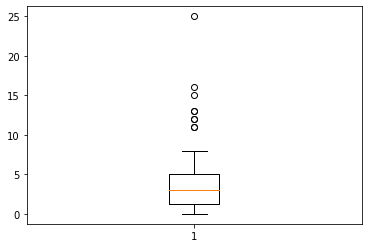

In [28]:
plt.boxplot(rent_ads_data['Етаж'])
plt.show()

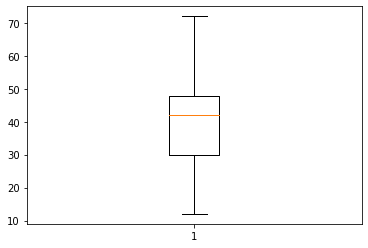

In [29]:
plt.boxplot(rent_ads_data['Площ'])
plt.show()

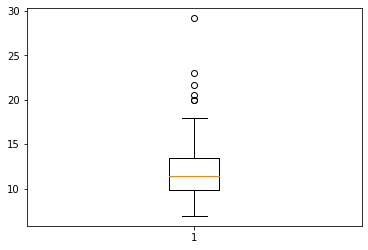

In [30]:
plt.boxplot(rent_ads_data['Цена на кв.м. (в лв.)'])
plt.show()

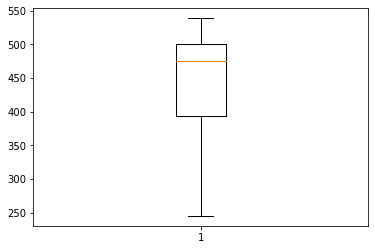

In [31]:
plt.boxplot(rent_ads_data['Наем (в лв.)'])
plt.show()

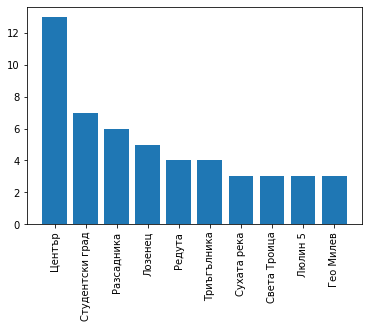

In [32]:
plt.bar(rent_ads_data['Район/Квартал'].value_counts().index[:10], rent_ads_data['Район/Квартал'].value_counts().values[:10])
plt.xticks(rotation = 90)
plt.show()

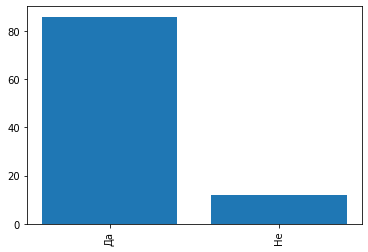

In [33]:
# plt.figure(figsize=(10, 7))
plt.bar(rent_ads_data['От агенция'].value_counts().index, rent_ads_data['От агенция'].value_counts().values)
plt.xticks(rotation = 90)
plt.show()

### Target променлива

In [34]:
 rent_ads_data['Идентифициран риск за фалшива обява'].value_counts()

Не    88
Да    10
Name: Идентифициран риск за фалшива обява, dtype: int64

Данните имат общо 98 записа, като класовете са силно небалансирани, с една 10 записа за клас - 0/'Да'.

## Моделиране по features 

#### Премахване на колони

От данните се премахват колоните с дата на публикуване, телефон,  както и текста към обявата(`Заглавие` и `Описание`). Колоната 'Подател' също няма да се използва тъй като след превръщане на категориите в нея към индикаторни променливи, данните ще имат повече измерения, отколкото записи. Информация за подателя на обявата се получава от части от колоната с колона `От агенция`, която показва дали обявата е частна или от агенция за недвижими имоти. Колона `Идентифициран риск за фалшива обява` се изнася като отделна target промелнива.

In [35]:
rent_ads_attributes = rent_ads_data.drop(['Дата на публикуване', 'Заглавие', 'Описание', 'Телефон', 'Подател', 'Идентифициран риск за фалшива обява'], axis=1)

In [36]:
rent_ads_target = rent_ads_data['Идентифициран риск за фалшива обява']

In [37]:
rent_ads_target.value_counts()

Не    88
Да    10
Name: Идентифициран риск за фалшива обява, dtype: int64

#### Превръщане на категориини променливи в индикаторни

In [38]:
rent_ads_attributes = pd.get_dummies(rent_ads_attributes, drop_first=True)

In [39]:
rent_ads_attributes.head(1)

,Етаж,Наем (в лв.),Наем (в евро),Площ,Цена на кв.м. (в лв.),Спални,Град_Божурище,Град_Нови хан,Град_София,Град_к.к.Боровец,...,Район/Квартал_Редута,Район/Квартал_Света Троица,Район/Квартал_Свобода,Район/Квартал_Студентски град,Район/Квартал_Сухата река,Район/Квартал_Триъгълника,Район/Квартал_Хаджи Димитър,Район/Квартал_Център,Район/Квартал_Яворов,От агенция_Не
Обява №,,,,,,,,,,,,,,,,,,,,,
1276,8.0,539.0,275.0,49.0,10.976597,1.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
rent_ads_target = pd.get_dummies(rent_ads_target, drop_first=True)

### с oversampling

#### Балансиране на класовете чрез SMOTE

In [41]:
rent_ads_attributes_balanced, rent_ads_target_balanced = SMOTE(random_state=13).fit_resample(rent_ads_attributes, rent_ads_target)

#### Скалиране

Поради не малките разлики в стойностите на различните колони, данните ще бъдат скалирани, изполвайки MinMaxScaler. По този начин максималната стойност за съответната колона ще бъде равна на 1, а минималната на 0.

In [43]:
scaler = MinMaxScaler()

In [44]:
scaler.fit(rent_ads_attributes_balanced)

MinMaxScaler()

In [45]:
rent_ads_attributes_scaled = scaler.transform(rent_ads_attributes_balanced)

#### Разделяне на данните на трениращи и тестови

Вече скалираните данни ще бъдат разделени на тестови - 30% и трениращи - 70%. Тъй като класовете вече са балансирани, всеки клас ще има приблизително еднакъв брой записи в съответния сет.

In [46]:
rent_ads_attributes_train, rent_ads_attributes_test, rent_ads_target_train, rent_ads_target_test = train_test_split(rent_ads_attributes_scaled,
                                                                                                                    rent_ads_target_balanced,
                                                                                                                    test_size=0.3,
                                                                                                                    random_state=13)                                                                                                                  

In [47]:
rent_ads_attributes_train.shape, rent_ads_attributes_test.shape, rent_ads_target_train.shape,rent_ads_target_test.shape

((123, 58), (53, 58), (123, 1), (53, 1))

In [48]:
rent_ads_target_test.value_counts()

Не
1     27
0     26
dtype: int64

In [49]:
rent_ads_target_train.value_counts()

Не
0     62
1     61
dtype: int64

In [50]:
rent_ads_target_train = np.ravel(rent_ads_target_train)

In [51]:
rent_ads_target_test = np.ravel(rent_ads_target_test)

#### Оптимизация на хиперпараметри и трениране на модел

In [52]:
#### Support vector classifier

In [53]:
grid_params = {'C': [0.1, 1, 10],
               'kernel': ['linear', 'poly', 'rbf'],
               'gamma': [0.1, 1, 10]
}

In [54]:
grid_search = GridSearchCV(SVC(random_state=13), grid_params, scoring=make_scorer(f1_score))

In [55]:
grid_search.fit(rent_ads_attributes_train, rent_ads_target_train)

GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring=make_scorer(f1_score))

In [56]:
grid_search.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [57]:
grid_search.best_score_

0.9244214559386974

#### Оценка на модела върху трениращите данни

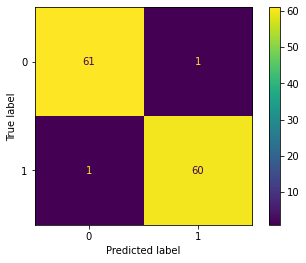

In [58]:
ConfusionMatrixDisplay(confusion_matrix(rent_ads_target_train, grid_search.best_estimator_.predict(rent_ads_attributes_train))).plot()
plt.show()

In [59]:
f1_score(rent_ads_target_train, grid_search.best_estimator_.predict(rent_ads_attributes_train))

0.9836065573770492

In [60]:
print(classification_report(rent_ads_target_train, grid_search.best_estimator_.predict(rent_ads_attributes_train)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        62
           1       0.98      0.98      0.98        61

    accuracy                           0.98       123
   macro avg       0.98      0.98      0.98       123
weighted avg       0.98      0.98      0.98       123



#### Оценка на модела върху тестовите данни

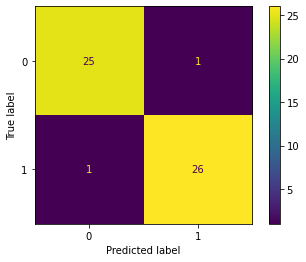

In [61]:
ConfusionMatrixDisplay(confusion_matrix(rent_ads_target_test, grid_search.best_estimator_.predict(rent_ads_attributes_test))).plot()
plt.show()

In [62]:
f1_score(rent_ads_target_test, grid_search.best_estimator_.predict(rent_ads_attributes_test))

0.9629629629629629

In [63]:
print(classification_report(rent_ads_target_test, grid_search.best_estimator_.predict(rent_ads_attributes_test)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.96      0.96      0.96        27

    accuracy                           0.96        53
   macro avg       0.96      0.96      0.96        53
weighted avg       0.96      0.96      0.96        53



### без oversampling

#### Скалиране

In [64]:
scaler = MinMaxScaler()
scaler.fit(rent_ads_attributes_balanced)
rent_ads_attributes_scaled = scaler.transform(rent_ads_attributes)

#### Разделяне на данните на трениращи и тестови

In [65]:
rent_ads_attributes_train, rent_ads_attributes_test, rent_ads_target_train, rent_ads_target_test = train_test_split(rent_ads_attributes_scaled,
                                                                                                                    rent_ads_target,
                                                                                                                    test_size=0.3,
                                                                                                                    random_state=13, 
                                                                                                                    stratify=rent_ads_target)                                                                                                                  

In [66]:
rent_ads_target_test.value_counts()

Не
1     27
0      3
dtype: int64

In [67]:
rent_ads_target_train.value_counts()

Не
1     61
0      7
dtype: int64

In [68]:
rent_ads_target_train = np.ravel(rent_ads_target_train)
rent_ads_target_test = np.ravel(rent_ads_target_test)

#### Оптимизация на хиперпараметри и трениране на модел

In [69]:
LinearSVC

sklearn.svm._classes.LinearSVC

In [70]:
grid_params = {'C': [0.001, 0.01, 0.1, 1, 10],
               'fit_intercept': [True, False]
}

In [71]:
grid_search = GridSearchCV(LinearSVC(random_state=13, class_weight='balanced'), grid_params, scoring=make_scorer(f1_score))

In [72]:
grid_search.fit(rent_ads_attributes_train, rent_ads_target_train)

/home/ivelina/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ivelina/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ivelina/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ivelina/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ivelina/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ivelina/anaconda3/envs/ML/lib/python3.8/site-pack

GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=13),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False]},
             scoring=make_scorer(f1_score))

In [73]:
grid_search.best_params_

{'C': 0.01, 'fit_intercept': True}

In [74]:
grid_search.best_score_

0.893304347826087

#### Оценка на модела върху трениращите данни

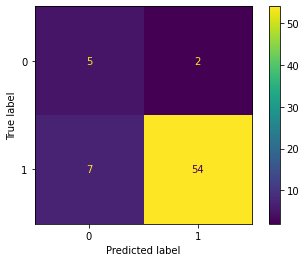

In [75]:
ConfusionMatrixDisplay(confusion_matrix(rent_ads_target_train, grid_search.best_estimator_.predict(rent_ads_attributes_train))).plot()
plt.show()

#### Оценка на модела върху тестовите данни

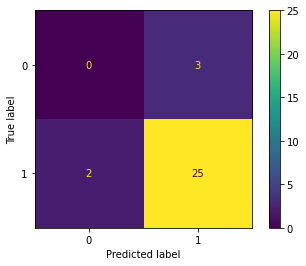

In [76]:
ConfusionMatrixDisplay(confusion_matrix(rent_ads_target_test, grid_search.best_estimator_.predict(rent_ads_attributes_test))).plot()
plt.show()